#Predicting oil price using PGM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install EIA_python

In [ ]:
import eia
eia_key = ""
eia_api = eia.API(eia_key)

In [ ]:
import requests

# EIA API key and series ID
eia_key = ""

def get_eia_data(series_id):
  # API v2 endpoint
  url = f"https://api.eia.gov/v2/seriesid/{series_id}"

  # Make the API request
  params = {"api_key": eia_key}
  response = requests.get(url, params=params)

  # Check response status
  if response.status_code == 200:
      # Parse JSON response
      data = response.json()

      if 'response' in data and 'data' in data['response']:
          # Extract the data
          series_data = data['response']['data']

          # Convert to DataFrame
          eia_data = pd.DataFrame(series_data)
          try:
            eia_data = eia_data[['period', 'value']]
            eia_data['value'] = pd.to_numeric(eia_data['value'], errors='coerce')
            eia_data.rename(columns={'value': series_id}, inplace=True)
          except Exception as e:
            print(f"An unexpected error occurred: {e}")

          #print(eia_data)
          return eia_data
      else:
          print("Error: No data found in response.")
  else:
      print(f"Error: HTTP {response.status_code} - {response.text}")

In [ ]:
eia_data = get_eia_data('STEO.PAPR_NONOPEC.M')
eia_data.head(n=10)

,period,STEO.PAPR_NONOPEC.M
0,2026-12,73.458012
1,2026-11,73.771476
2,2026-10,73.316524
3,2026-09,73.119384
4,2026-08,73.261458
5,2026-07,73.369959
6,2026-06,73.264053
7,2026-05,72.893816
8,2026-04,72.801087
9,2026-03,72.664908


In [ ]:
eia_data.head(n=10)
eia_data_copy = eia_data.copy()

In [ ]:
eia_data = eia_data_copy.copy()

In [ ]:
def set_datetime_index(df, date_column='period'):
    """
    Converts a specified column in a DataFrame to datetime and sets it as the index.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        date_column (str): The column to convert to datetime and set as the index.

    Returns:
        pd.DataFrame: The DataFrame with a datetime index.
    """
    # Convert the date column to datetime
    df[date_column] = pd.to_datetime(df[date_column], format='%Y-%m')

    # Set the date column as the index
    df.set_index(date_column, inplace=True)

    # Ensure the index is sorted
    df.sort_index(inplace=True)

    return df

In [ ]:
def clean_EIA(data):
  data = set_datetime_index(data)
  # Replace the '-' with np.nan
  data.replace('-', np.nan, regex=True, inplace=True)
  # Backward fill the holes, by filling them with the data infront.
  data.fillna(method='bfill', inplace=True)

clean_EIA(eia_data)

<ipython-input-8-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [ ]:
eia_data.head(n=10)

,STEO.PAPR_NONOPEC.M
period,
1993-01-01,42.381897
1993-02-01,42.260014
1993-03-01,42.213345
1993-04-01,42.025591
1993-05-01,41.962095
1993-06-01,41.515384
1993-07-01,41.857326
1993-08-01,41.735946
1993-09-01,41.667424


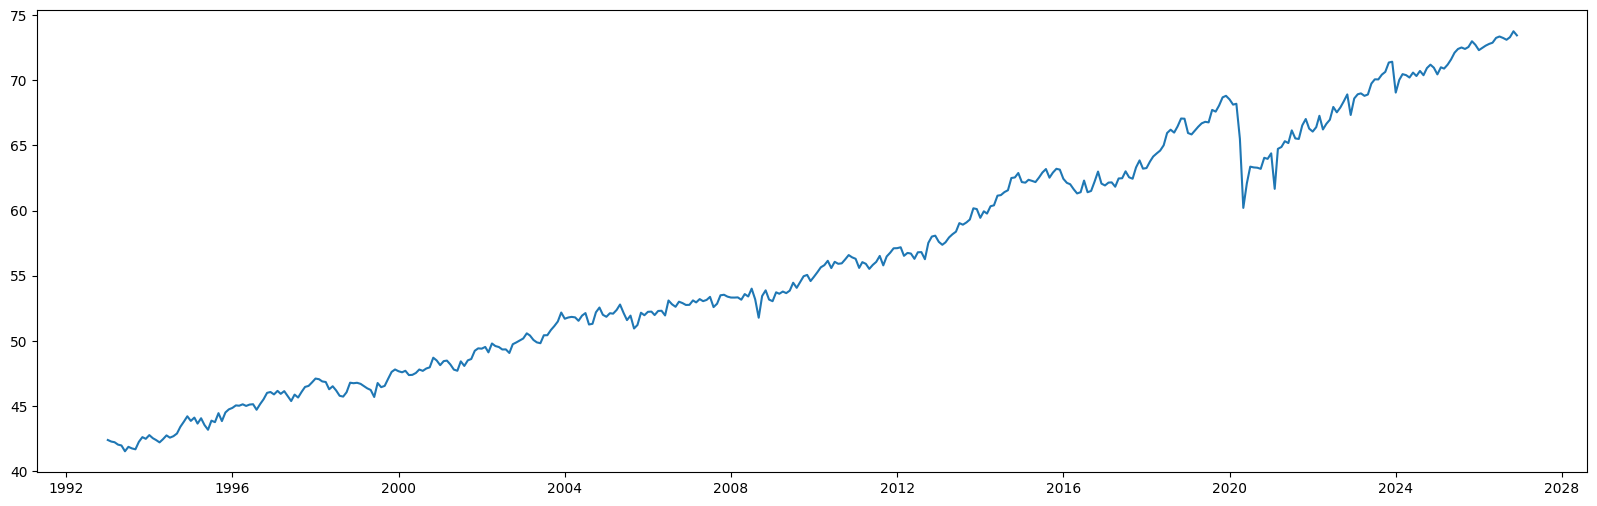

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(eia_data)

In [ ]:
!pip install fredapi

In [ ]:
from fredapi import Fred

In [ ]:
fred_key = ""

In [ ]:
fred = Fred(api_key=fred_key)

In [ ]:
fred_data = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC'])

In [ ]:
fred_data.head()

,WTISPLC
1946-01-01,1.17
1946-02-01,1.17
1946-03-01,1.17
1946-04-01,1.27
1946-05-01,1.27


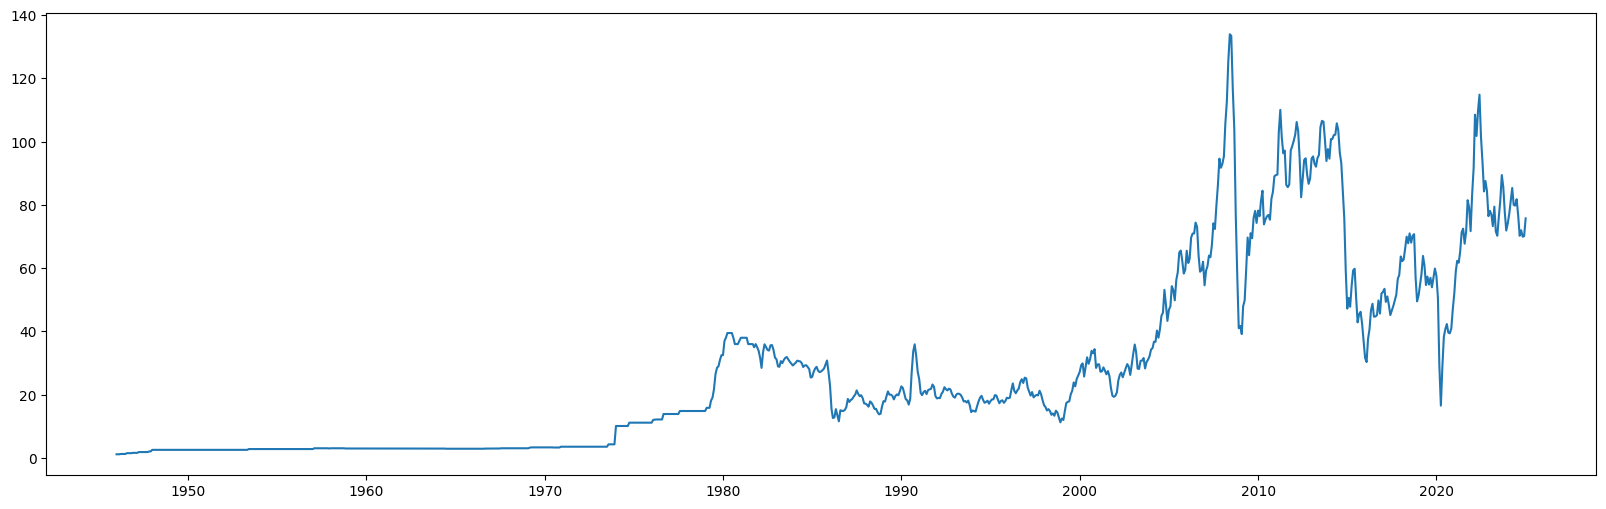

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(fred_data)

In [ ]:
# Dataset series ID from the EIA
datasets_eia = [
    'STEO.PAPR_NONOPEC.M',
    'STEO.PAPR_OPEC.M',
    'STEO.PATC_OECD.M',
    'STEO.PATC_NON_OECD.M',
    'STEO.COPRPUS.M',
    'STEO.CORIPUS.M',
    'PET.MCRIMXX2.M',
    'STEO.FOREX_WORLD.M',
    'STEO.PASC_OECD_T3.M',
    'STEO.COPS_OPEC.M',
    'STEO.COPC_OPEC.M',
    'STEO.T3_STCHANGE_OOECD.M',
    'STEO.T3_STCHANGE_NOECD.M',
]

# Dataset series ID from the FRED
datasets_fred = [
    'CPIENGSL',
    'CAPG211S',
    'CAPUTLG211S',
    'IPG211S',
    'IPG211111CN',
    'INDPRO',
    'IPN213111N',
    'PCU211211',
]

In [ ]:
data_merge = [] # List of dataframes to be concatenated
# Adding EIA datasets
for series_id in datasets_eia:
    df = get_eia_data(series_id)
    if df.empty:
        continue
    clean_EIA(df)
    df.columns = [series_id]
    data_merge.append(df)

# Adding FRED datasets
for series_id in datasets_fred:
    df = pd.DataFrame(fred.get_series(series_id), columns=[series_id])
    data_merge.append(df)

<ipython-input-8-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-8-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-8-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-8-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-8-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill(

An unexpected error occurred: "None of [Index(['period', 'value'], dtype='object')] are in the [columns]"


<ipython-input-8-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-8-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-8-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-8-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-8-291d6e59003f>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill(

In [ ]:
datasets = datasets_eia + datasets_fred + ['WTISPLC', 'forecast']
current = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC'])
forecast = pd.DataFrame(fred.get_series('WTISPLC').shift(-1), columns=['forecast'])
data_merge.append(current)
data_merge.append(forecast)

In [ ]:
data = pd.concat(data_merge, axis=1, join='inner')

In [ ]:
data.head(n=10)

,STEO.PAPR_NONOPEC.M,STEO.PAPR_OPEC.M,STEO.PATC_OECD.M,STEO.PATC_NON_OECD.M,STEO.COPRPUS.M,STEO.CORIPUS.M,PET.MCRIMXX2.M,STEO.PASC_OECD_T3.M,STEO.COPS_OPEC.M,STEO.COPC_OPEC.M,...,CPIENGSL,CAPG211S,CAPUTLG211S,IPG211S,IPG211111CN,INDPRO,IPN213111N,PCU211211,WTISPLC,forecast
2003-02-01,50.572317,28.735148,51.833868,30.708553,5.782863,14.381,3672,2394.414000,2.364945,28.209000,...,140.8,64.3603,93.6988,60.3048,88.8760,91.2505,90.9680,170.2,35.87,33.55
2003-03-01,50.407735,29.375879,49.263850,30.374890,5.803461,14.933,4883,2463.397002,0.957693,27.399329,...,143.9,64.4112,93.0475,59.9331,89.1924,91.0006,92.6011,220.0,33.55,28.25
2003-04-01,50.062831,28.582918,48.385719,29.941029,5.725816,15.575,5279,2493.210998,0.820811,26.383232,...,136.5,64.4758,92.4022,59.5770,87.9987,90.4311,96.0623,150.2,28.25,28.14
2003-05-01,49.877436,28.720351,47.515790,30.425602,5.663475,15.910,5060,2541.263000,1.185702,26.939523,...,129.4,64.5475,90.8091,58.6150,87.0407,90.4000,101.5265,152.7,28.14,30.72
2003-06-01,49.815246,28.074057,48.119533,30.827331,5.659077,15.620,4722,2584.821001,2.138374,27.177749,...,129.8,64.6205,91.0159,58.8149,86.9731,90.5196,103.1308,169.3,30.72,30.76
2003-07-01,50.423767,28.300441,48.817290,31.127138,5.498445,15.546,4112,2610.785999,2.179302,27.339878,...,132.2,64.6870,90.2706,58.3934,84.5034,90.9869,104.0776,160.7,30.76,31.59
2003-08-01,50.429442,28.850976,48.396234,30.996413,5.573770,15.693,4347,2618.493000,2.195519,27.847362,...,137.8,64.7385,91.6009,59.3010,85.6613,90.7933,105.2404,151.1,31.59,28.29
2003-09-01,50.827849,29.239288,49.236955,31.209349,5.609009,15.446,4798,2632.882999,2.296769,28.287975,...,142.9,64.7704,92.1562,59.6899,86.2021,91.3819,105.5593,149.4,28.29,30.33
2003-10-01,51.128210,29.983055,49.977727,31.633777,5.613544,15.342,4754,2606.625001,2.075483,28.685975,...,137.8,64.7796,91.8105,59.4744,86.2716,91.5049,105.7384,146.1,30.33,31.09
2003-11-01,51.483127,29.994130,49.027725,31.645647,5.546554,15.455,4733,2609.821000,2.155300,28.745589,...,136.9,64.7640,91.0830,58.9890,85.2418,92.1265,106.4785,143.7,31.09,32.15


In [ ]:
train_data = data[: int(data.shape[0] * 0.80)]
vald_data = data[int(0.80 * data.shape[0]) : int(0.90 * data.shape[0])]
test_data = data[int(0.90* data.shape[0]) : int(data.shape[0])]

In [ ]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 5.5 MB/s eta 0:00:00


In [ ]:
from hmmlearn import hmm

# Step 1: Preprocess data
price = train_data['WTISPLC']
price_diff = price.diff()[1:]  # First differences
e_seq = np.array(price_diff.apply(lambda x: 1 if x > 0 else 0).values)  # Binary observations

# Step 2: Define and initialize HMM
n_states = 3  # Number of hidden states
n_observations = 2  # Number of discrete observations (0 or 1)
model = hmm.CategoricalHMM(n_components=n_states, n_iter=10000, tol=1e-14)

# Convert observations to a 2D array as required by hmmlearn
e_seq_reshaped = e_seq.reshape(-1, 1)

# Step 3: Train the HMM using Baum-Welch
model.fit(e_seq_reshaped)

# Print parameters
print("Transition Matrix:")
print(model.transmat_)
print("Emission Probabilities:")
print(model.emissionprob_)
print("Start Probabilities:")
print(model.startprob_)

# Step 4: Perform Viterbi decoding
log_prob, s_seq = model.decode(e_seq_reshaped, algorithm="viterbi")

# Output results
print("\nLog Probability of the sequence:", log_prob)
print("Most probable hidden state sequence:", s_seq)


Transition Matrix:
[[4.69885974e-01 5.30114026e-01 3.27995705e-14]
 [3.45510068e-17 7.22168920e-01 2.77831080e-01]
 [5.27764462e-01 1.32509344e-29 4.72235538e-01]]
Emission Probabilities:
[[1.00000000e+00 1.90051659e-12]
 [2.68697509e-01 7.31302491e-01]
 [6.50758755e-27 1.00000000e+00]]
Start Probabilities:
[1. 0. 0.]

Log Probability of the sequence: -149.88452633533126
Most probable hidden state sequence: [0 0 0 1 1 2 0 1 1 1 1 1 2 0 1 1 1 1 1 2 0 0 1 1 2 0 0 1 1 1 2 0 0 1 2 0 1
 1 1 1 2 0 0 0 1 2 0 1 1 2 0 1 2 0 1 1 2 0 1 1 1 1 1 2 0 0 0 0 0 0 1 1 1 1
 1 2 0 1 1 1 2 0 1 1 1 2 0 1 1 2 0 1 1 1 1 1 1 2 0 1 2 0 0 1 1 1 1 1 2 0 0
 0 1 1 2 0 0 1 1 2 0 0 1 1 1 2 0 0 0 1 1 2 0 1 1 2 0 0 0 0 0 0 0 1 1 1 1 2
 0 0 1 2 0 0 0 0 1 1 1 2 0 1 1 2 0 1 1 1 1 2 0 0 1 1]


In [ ]:
# Add price
price_plot = pd.DataFrame(price[1:], index=price[1:].index)

# Add a column representing the regime
price_plot['Regime'] = s_seq

# Add a column representing the increase or decrease in price
price_plot['diff'] = price_diff

# Get means of all assigned states
means = price_plot.groupby(['Regime'])['diff'].mean()
lst_1 = means.index.tolist()
lst_2 = means.sort_values().index.tolist()

map_regimes = dict(zip(lst_2, lst_1))

price_plot['Regime'] = price_plot['Regime'].map(map_regimes)

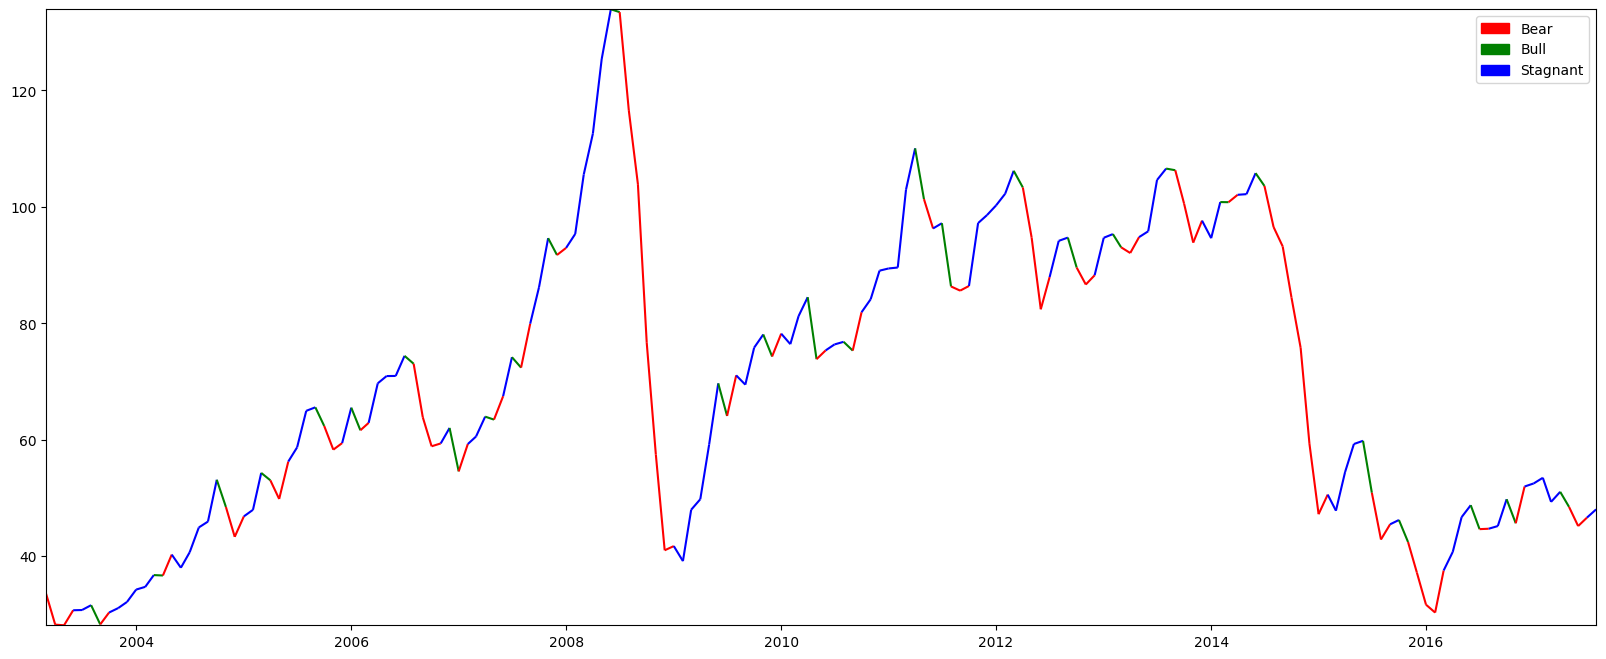

In [ ]:
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm

fig, ax1 = plt.subplots(figsize=(20,8))
ax.plot(price_plot['WTISPLC'])

# Make 0 (Bear)- red, 1 (Stagnant)- blue, 2 (Bull)- green
cmap = ListedColormap(['r','b','g'],'indexed')
norm = BoundaryNorm(range(3 + 1), cmap.N)
inxval = mdates.date2num(price_plot['WTISPLC'].index.to_pydatetime())
points = np.array([inxval, price_plot['WTISPLC']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(price_plot['Regime'])
plt.gca().add_collection(lc)
plt.xlim(price_plot['WTISPLC'].index.min(), price_plot['WTISPLC'].index.max())
plt.ylim(price_plot['WTISPLC'].min(), price_plot['WTISPLC'].max())
r_patch = mpatches.Patch(color='red', label='Bear')
g_patch = mpatches.Patch(color='green', label='Bull')
b_patch = mpatches.Patch(color='blue', label='Stagnant')
plt.legend(handles=[r_patch, g_patch, b_patch])
plt.show()

In [ ]:
import joblib
import os

os.makedirs("./hmms/", exist_ok=True)
for series_id in datasets:
  if series_id == 'forecast':
    break
  else:
    if series_id not in train_data:
      continue
    dhmm = hmm.CategoricalHMM(n_components=3, n_iter=10000, tol=1e-14)
    data_diff = train_data[series_id].diff()[1:]
    #emit_seq = np.array_split(data_diff.apply(lambda x: 1 if x > 0 else 0).values, 32)
    emit_seq = data_diff.apply(lambda x: 1 if x > 0 else 0).values
    emit_seq_reshaped = emit_seq.reshape(-1, 1)
    dhmm.fit(emit_seq_reshaped)
    path = "./hmms/" + series_id.replace(".", "_")
    joblib.dump(dhmm, path)

In [ ]:
disc_test = pd.DataFrame(index = train_data[1:].index)
os.makedirs("./data/", exist_ok=True)
for series_id in datasets:
   path = "./hmms/" + series_id.replace(".", "_")
   if series_id == 'forecast':
    dhmm = joblib.load('./hmms/WTISPLC')
   else:
    if series_id not in train_data:
      continue
    dhmm = joblib.load(path)
   data_diff = train_data[series_id].diff()[1:]
   emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values)
   emit_seq_reshaped = emit_seq.reshape(-1, 1)
   log_prob, s_seq = dhmm.decode(emit_seq_reshaped, algorithm="viterbi")
   disc_test[series_id] = s_seq
disc_test.to_csv("./data/train_data.csv")

In [ ]:
states = pd.read_csv("./data/train_data.csv", index_col=0)
os.makedirs("./plots/", exist_ok=True)

for series_id in datasets:
  if series_id not in train_data:
    continue
  df = pd.DataFrame(index=train_data[1:].index)
  df[series_id] = train_data[series_id][1:]
  df['Diff'] = train_data[series_id].diff()[1:]
  df['Regime'] = states[series_id]
  # Get means of all assigned states
  means = df.groupby(['Regime'])['Diff'].mean()
  lst_1 = means.index.tolist()
  lst_2 = means.sort_values().index.tolist()
  map_regimes = dict(zip(lst_2, lst_1))
  df['Regime'] = df['Regime'].map(map_regimes)

  cmap= ListedColormap(['r','b','g'],'indexed')
  norm = BoundaryNorm(range(3 + 1), cmap.N)
  inxval = mdates.date2num(df[series_id].index.to_pydatetime())
  points = np.array([inxval, df[series_id]]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  lc = LineCollection(segments, cmap=cmap, norm=norm)
  lc.set_array(df['Regime'])
  plt.gca().add_collection(lc)
  plt.xlim(df[series_id].index.min(), df[series_id].index.max())
  plt.ylim(df[series_id].min(), df[series_id].max())
  r_patch = mpatches.Patch(color='red', label='Bear')
  g_patch = mpatches.Patch(color='green', label='Bull')
  b_patch = mpatches.Patch(color='blue', label='Stagnant')
  plt.legend(handles=[r_patch, g_patch, b_patch])
  name = "./plots/" + series_id.replace(".", "_") + ".png"
  plt.savefig(name)
  plt.close()

In [ ]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import BicScore, K2Score

# Retrieve training set
train_data = pd.read_csv("./data/train_data.csv", index_col=0)
hc = HillClimbSearch(train_data, scoring_method=K2Score(train_data))
expert = BayesianModel()
expert.add_nodes_from(datasets)
expert.add_edges_from([
  ('STEO.PAPR_NONOPEC.M', 'WTISPLC'),
  ('STEO.PAPR_OPEC.M', 'WTISPLC'),
  ('STEO.PATC_OECD.M', 'WTISPLC'),
  ('STEO.PATC_NON_OECD.M', 'WTISPLC'),
  ('STEO.RGDPQ_OECD.M', 'STEO.PATC_OECD.M'),
  ('STEO.RGDPQ_NONOECD.M', 'STEO.PATC_NON_OECD.M'),
 ])

model = hc.estimate(expert); # Performs local hill climb search
model.fit(train_data,
          state_names=dict(map(lambda e: (e, [0, 1, 2]), datasets)),
          estimator=BayesianEstimator, prior_type="K2")


TypeError: BaseEstimator.__init__() got an unexpected keyword argument 'scoring_method'

In [ ]:
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BayesianEstimator, K2Score

# Load training data
train_data = pd.read_csv("./data/train_data.csv", index_col=0)

# Define dataset columns
datasets = list(train_data.columns)

# Define expert model with predefined edges
expert_edges = [
    ('STEO.PAPR_NONOPEC.M', 'WTISPLC'),
    ('STEO.PAPR_OPEC.M', 'WTISPLC'),
    ('STEO.PATC_OECD.M', 'WTISPLC'),
    ('STEO.PATC_NON_OECD.M', 'WTISPLC'),
    ('STEO.RGDPQ_OECD.M', 'STEO.PATC_OECD.M'),
    ('STEO.RGDPQ_NONOECD.M', 'STEO.PATC_NON_OECD.M'),
]

# Perform structure learning with HillClimbSearch
hc = HillClimbSearch(train_data)
dag = hc.estimate(scoring_method=K2Score(train_data))  # Learn structure from data

# Convert DAG to BayesianModel
learned_model = BayesianModel(dag.edges())

# Ensure all nodes are present
learned_model.add_nodes_from(datasets)

# Ensure all nodes have data
for node in learned_model.nodes():
    if node not in train_data.columns:
        print(f"⚠️ Warning: No data found for {node}. Removing from model.")
        learned_model.remove_node(node)

# Add expert-defined edges only if they don't create a cycle
for edge in expert_edges:
    learned_model.add_edge(*edge)
    if not learned_model.check_model():  # Check for cycles
        learned_model.remove_edge(*edge)  # Remove if it forms a loop
        print(f"⚠️ Skipping edge {edge} to prevent a cycle.")

# Fit the final Bayesian model
learned_model.fit(
    train_data,
    state_names={col: train_data[col].dropna().unique().tolist() for col in train_data.columns if col in learned_model.nodes()},
    estimator=BayesianEstimator,
    prior_type="K2"
)

# Print the final learned structure
print("Final Model Edges:", learned_model.edges())


  0%|          | 0/1000000 [00:00<?, ?it/s]

ValueError: No CPD associated with STEO.PAPR_NONOPEC.M